In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.decomposition import PCA

In [2]:
# --- Load datasets ---
save_path = 'C:/Users/anhuy/CS-5806/Project/data/processed'

X_full = pd.read_csv(os.path.join(save_path, 'X_full_cleaned.csv'))
X_sub = pd.read_csv(os.path.join(save_path, 'X_subsampled.csv'))

y_full = pd.read_csv(os.path.join(save_path, 'y_full_cleaned.csv')).squeeze()
y_sub = pd.read_csv(os.path.join(save_path, 'y_subsampled.csv')).squeeze()

lat_lon_full = pd.read_csv(os.path.join(save_path, 'lat_lon_full_cleaned.csv'))
original_index_full = pd.read_csv(os.path.join(save_path, 'original_index_full_cleaned.csv')).squeeze()

In [3]:
def combined_histograms_twiny(X_full, X_sub, title_prefix=''):
    num_features = X_full.shape[1]
    n_cols = 4  # More compact: 4 plots per row
    n_rows = int(np.ceil(num_features / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    for idx, col in enumerate(X_full.columns):
        ax1 = axes[idx]
        ax2 = ax1.twinx()

        # Plot Full dataset
        ax1.hist(X_full[col], bins=50, alpha=0.5, label='Full', color='blue', edgecolor='black')
        ax1.set_ylabel('Full Count', color='blue', fontsize=8)
        ax1.tick_params(axis='y', labelcolor='blue', labelsize=8)

        # Plot Subsampled dataset
        ax2.hist(X_sub[col], bins=50, alpha=0.5, label='Subsampled', color='orange', edgecolor='black')
        ax2.set_ylabel('Subsampled Count', color='orange', fontsize=8)
        ax2.tick_params(axis='y', labelcolor='orange', labelsize=8)

        # Titles and grid
        ax1.set_title(f'{col}', fontsize=10)
        ax1.grid(True, which='both', linestyle='--', alpha=0.5)

        # Combined legends
        h1, l1 = ax1.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        ax1.legend(h1+h2, l1+l2, loc='upper right', fontsize=7)

    # Hide extra empty axes
    for j in range(num_features, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(h_pad=2.0)  # First, arrange plots tightly
    fig.suptitle(f'{title_prefix} Histograms (Full vs Subsampled)', fontsize=24, y=1.02)
    plt.show()

def plot_combined_y_histogram(y_full, y_sub, title="Combined Histogram of Target (UHII)"):
    fig, ax1 = plt.subplots(figsize=(6, 4))

    # Left y-axis: Full
    ax1.hist(y_full, bins=50, alpha=0.6, label='Full Cleaned', color='blue', edgecolor='black')
    ax1.set_ylabel('Full Cleaned Count', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Right y-axis: Subsampled
    ax2 = ax1.twinx()
    ax2.hist(y_sub, bins=50, alpha=0.4, label='Subsampled', color='orange', edgecolor='black')
    ax2.set_ylabel('Subsampled Count', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    # Labels and Titles
    ax1.set_title(title, fontsize=12)
    ax1.set_xlabel('UHII Value')
    ax1.grid(True, which='both', linestyle='--', alpha=0.5)

    # Merge Legends
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper right', fontsize=10)

    plt.tight_layout()
    plt.show()

def plot_pca_projection(X_full, X_sub, n_components=2, title="PCA Projection of X Features (Full vs Subsampled)"):
    # --- Step 1: Fit PCA on full dataset ---
    pca = PCA(n_components=n_components)
    X_full_pca = pca.fit_transform(X_full)
    X_sub_pca = pca.transform(X_sub)  # Project subsampled onto the same PCA basis

    print(f"Explained variance ratio (first {n_components} components): {pca.explained_variance_ratio_}")

    # --- Step 2: Plot ---
    plt.figure(figsize=(6, 4))

    plt.scatter(X_full_pca[:, 0], X_full_pca[:, 1], alpha=0.3, label='Full Cleaned', color='blue', s=10)
    plt.scatter(X_sub_pca[:, 0], X_sub_pca[:, 1], alpha=0.5, label='Subsampled', color='orange', s=15)

    plt.title(title, fontsize=12)
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

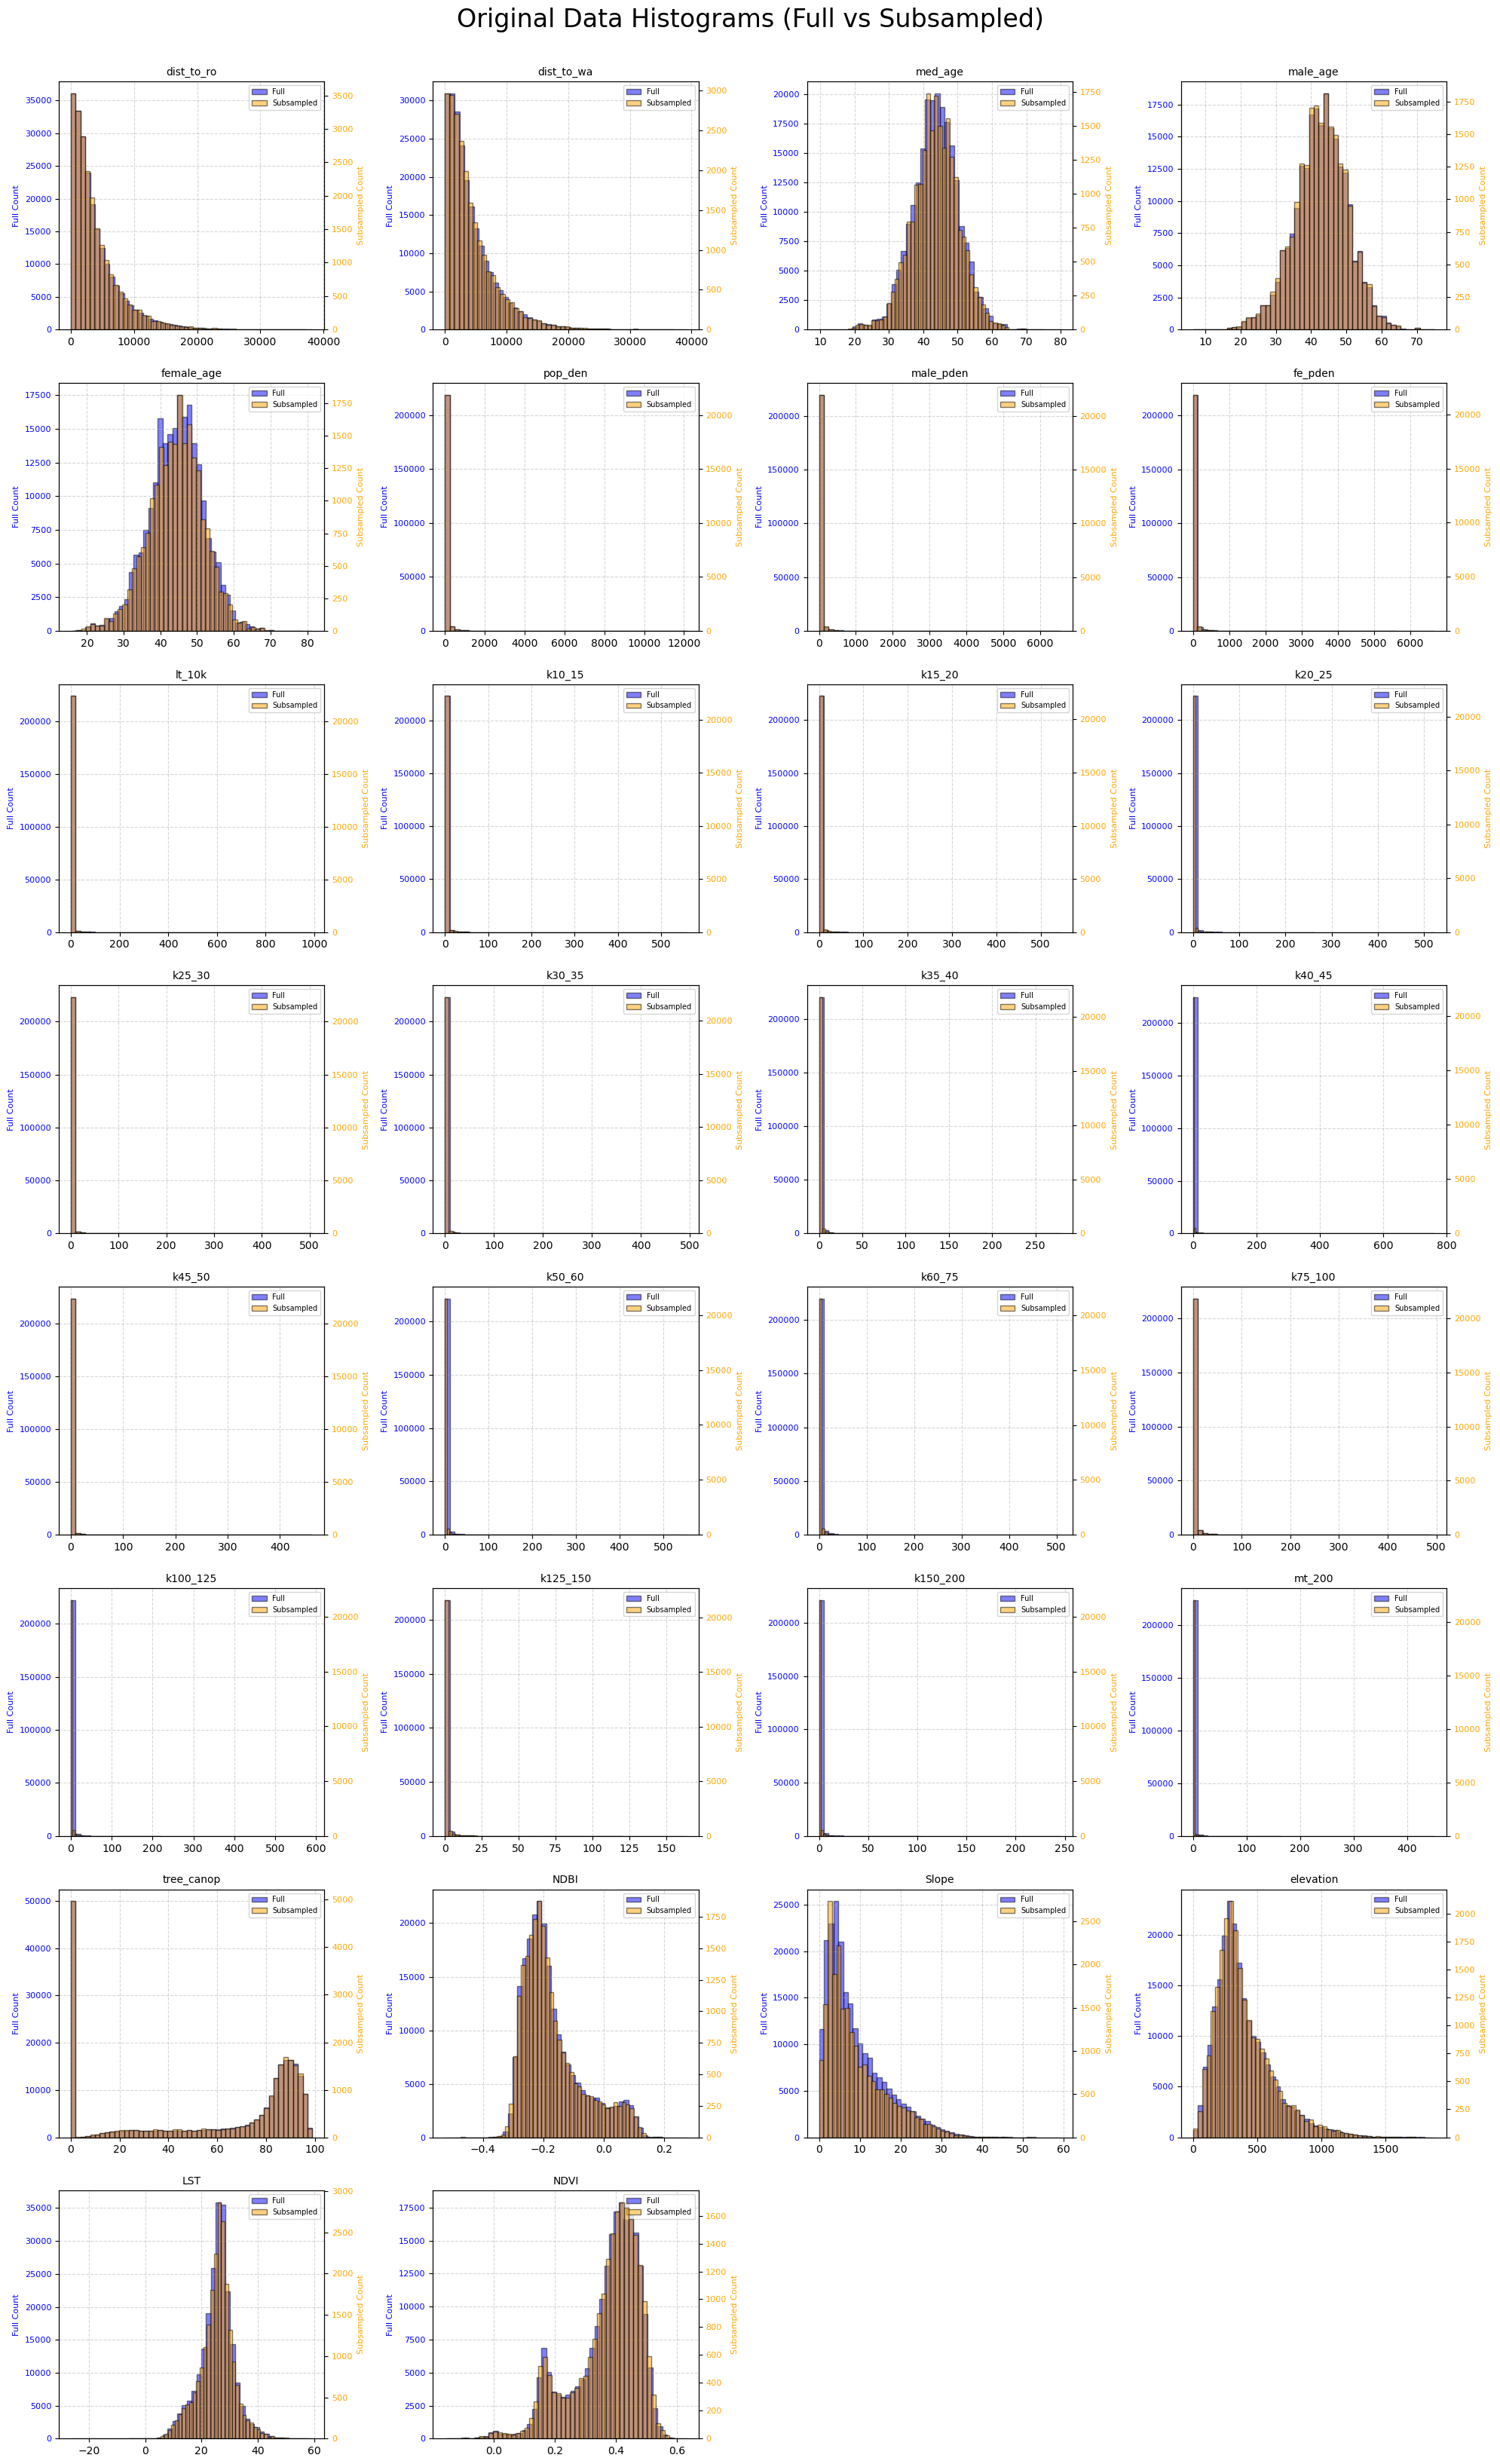

In [4]:
combined_histograms_twiny(X_full, X_sub, title_prefix='Original Data')

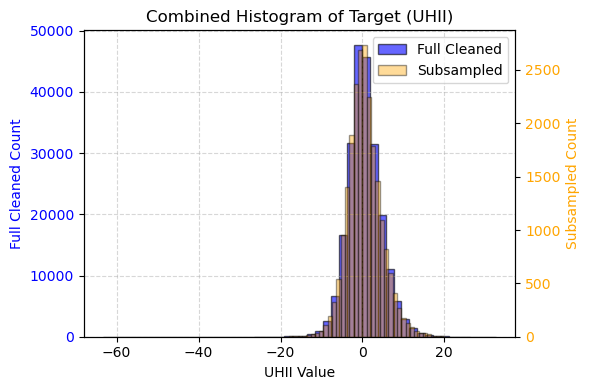

In [5]:
plot_combined_y_histogram(y_full, y_sub, title="Combined Histogram of Target (UHII)")

Explained variance ratio (first 2 components): [0.97065929 0.0267166 ]


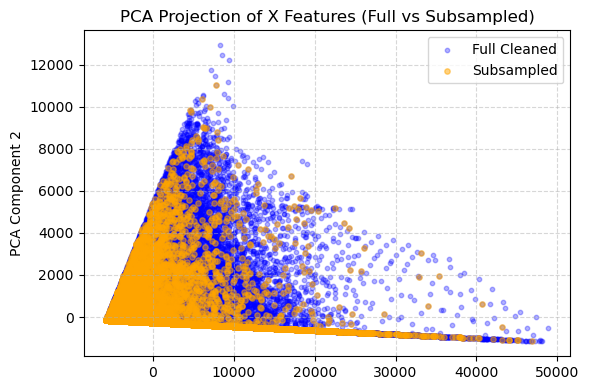

In [6]:
plot_pca_projection(X_full, X_sub, n_components=2, title="PCA Projection of X Features (Full vs Subsampled)")

After trimming:
- X shape: (181737, 30)
- y shape: (181737,)
- lat_lon shape: (181737, 2)
- original_index shape: (181737,)

After downsampling:
- Downsampled X shape: (18174, 30)
- Downsampled y shape: (18174,)
- Downsampled lat_lon shape: (18174, 2)
- Downsampled original_index shape: (18174,)


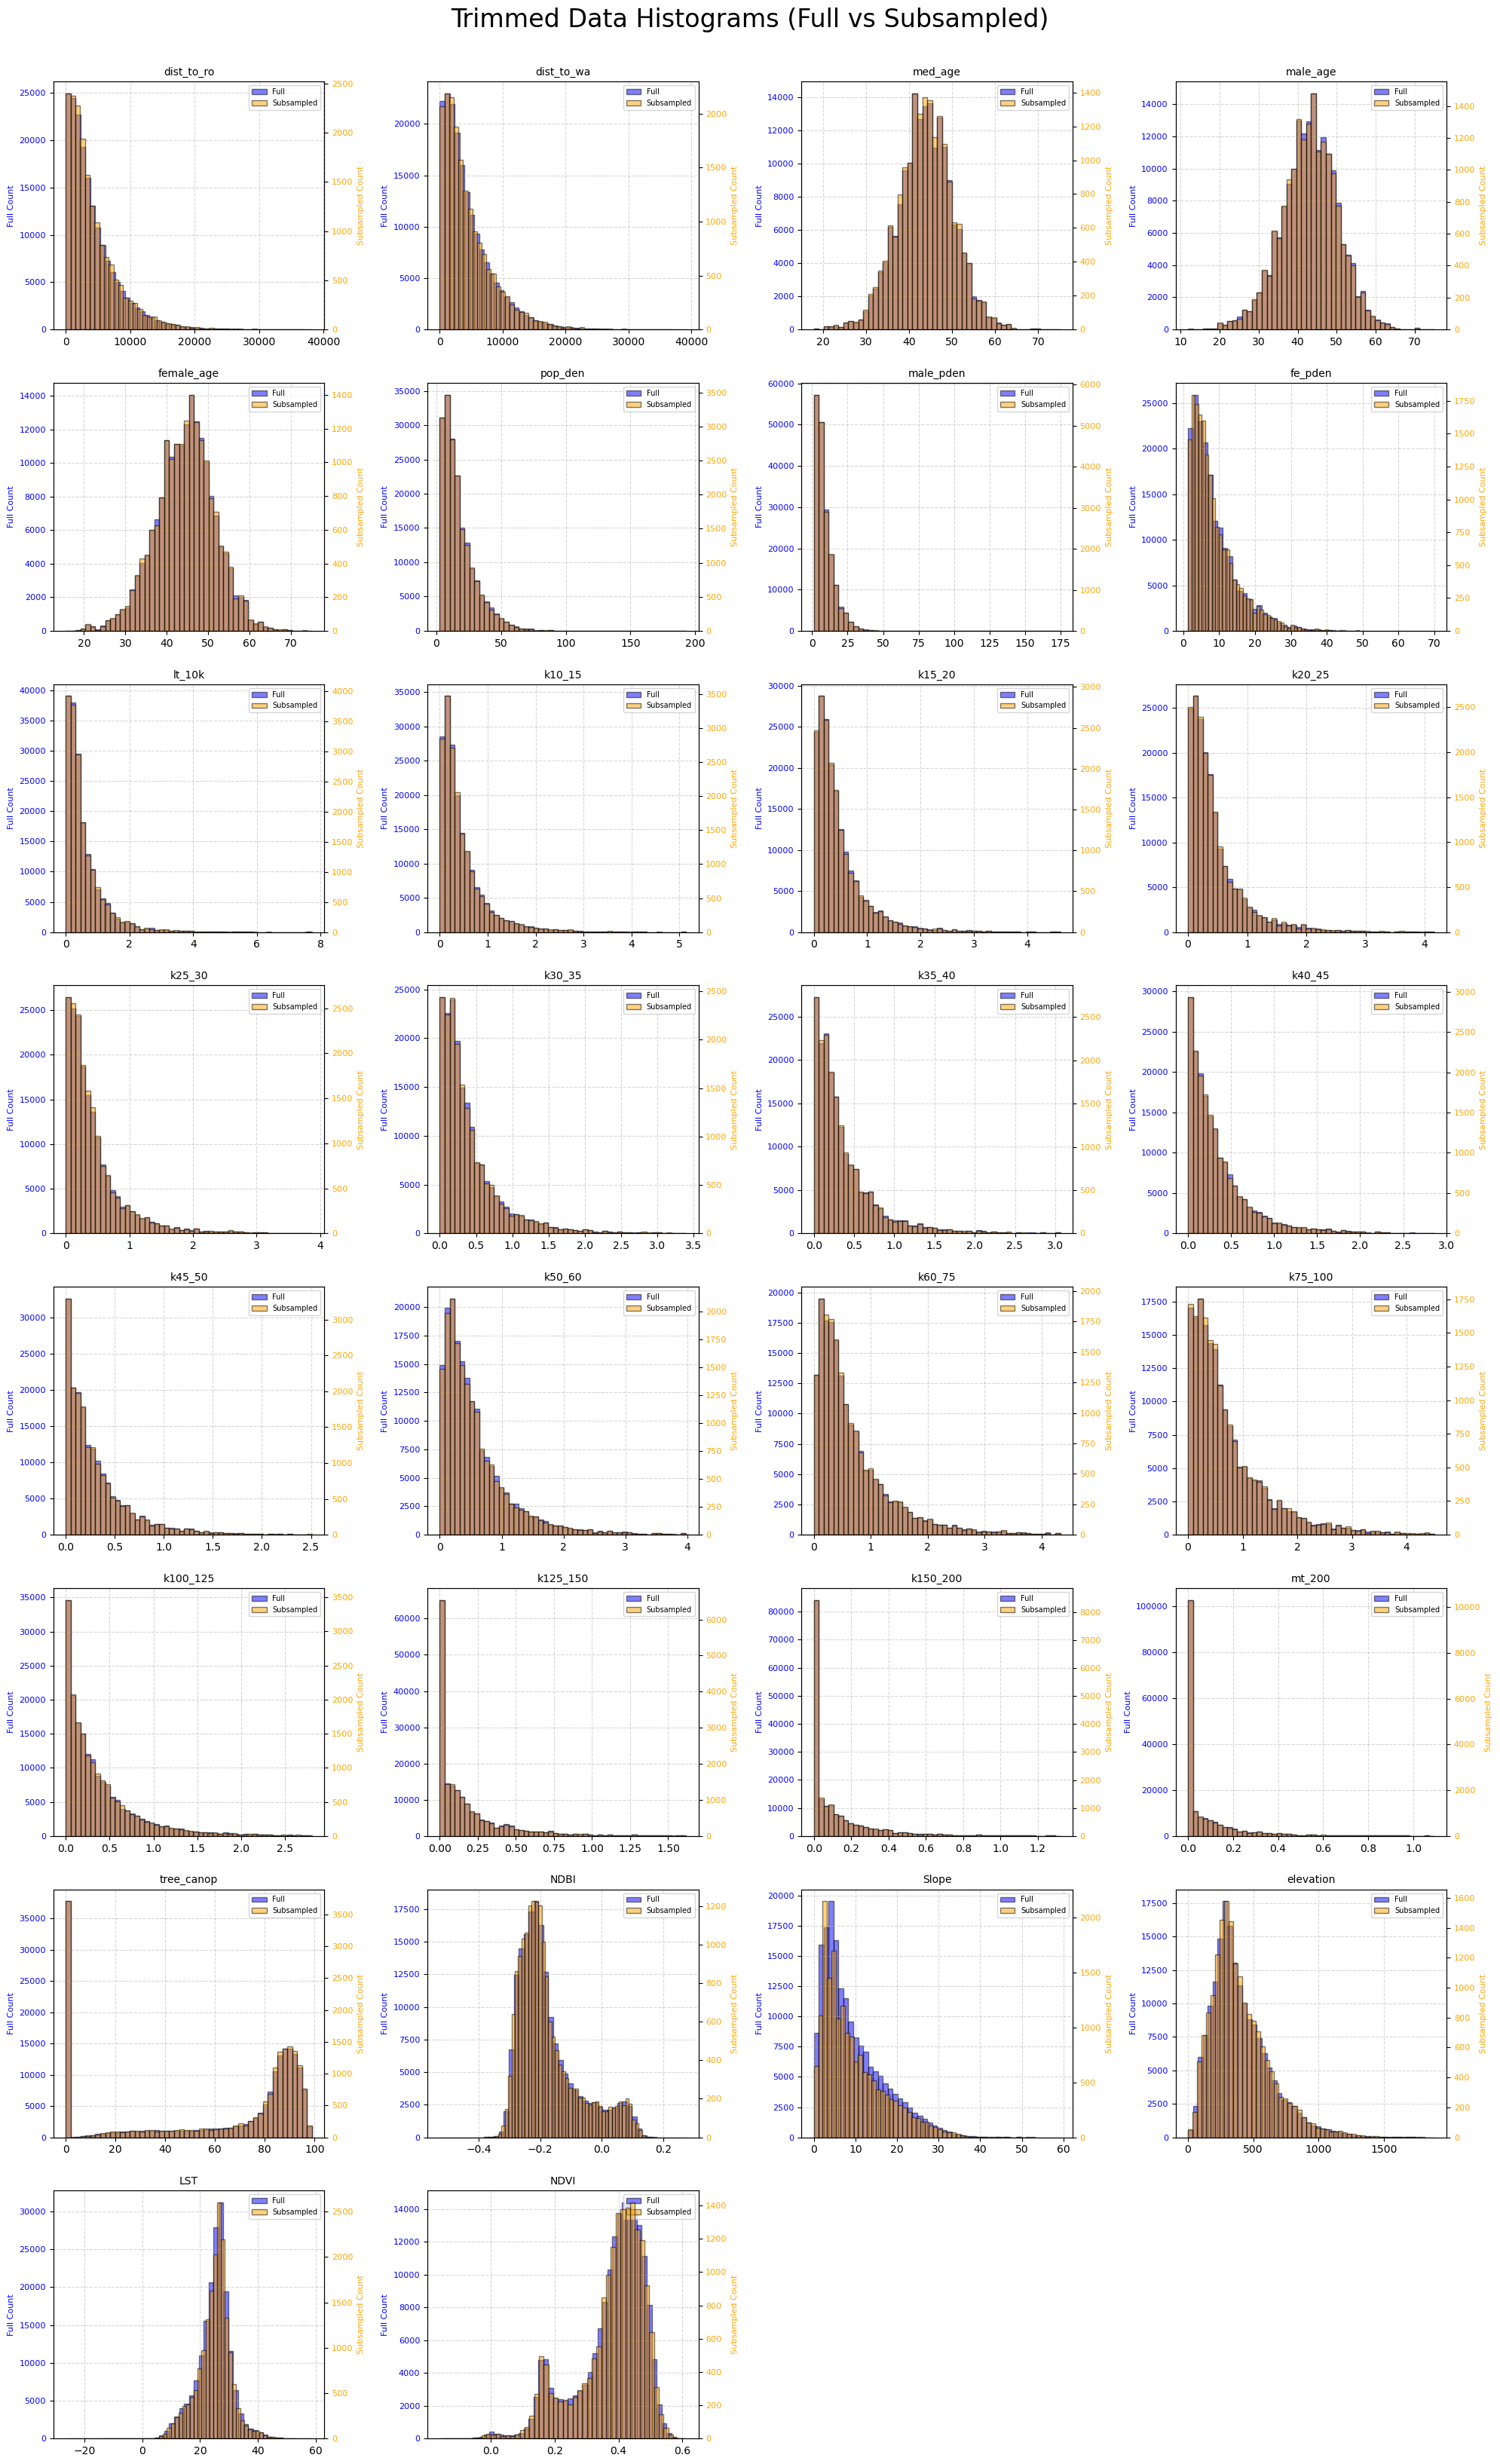

In [7]:
# --- Step 1: List of features you want to trim ---
features_to_trim = [
    'pop_den', 'male_pden', 'fe_pden',  # Population density related
    'lt_10k', 'k10_15', 'k15_20', 'k20_25', 'k25_30', 'k30_35', 'k35_40',
    'k40_45', 'k45_50', 'k50_60', 'k60_75', 'k75_100', 'k100_125',
    'k125_150', 'k150_200', 'mt_200'  # KT-related features
]

# --- Step 2: Trim based on percentiles (1% and 99%) ---
trim_percent = 0.01  # 1%

X_full_trimmed = X_full.copy()
y_full_trimmed = y_full.copy()
lat_lon_full_trimmed = lat_lon_full.copy()
original_index_full_trimmed = original_index_full.copy()

for col in features_to_trim:
    lower = X_full_trimmed[col].quantile(trim_percent)
    upper = X_full_trimmed[col].quantile(1 - trim_percent)

    mask = (X_full_trimmed[col] >= lower) & (X_full_trimmed[col] <= upper)

    # Apply mask to X, y, lat_lon, and original_index
    X_full_trimmed = X_full_trimmed[mask]
    y_full_trimmed = y_full_trimmed.loc[X_full_trimmed.index]
    lat_lon_full_trimmed = lat_lon_full_trimmed.loc[X_full_trimmed.index]
    original_index_full_trimmed = original_index_full_trimmed.loc[X_full_trimmed.index]

print(f"After trimming:")
print(f"- X shape: {X_full_trimmed.shape}")
print(f"- y shape: {y_full_trimmed.shape}")
print(f"- lat_lon shape: {lat_lon_full_trimmed.shape}")
print(f"- original_index shape: {original_index_full_trimmed.shape}")

# --- Step 3: Create Downsampled Dataset ---

subsample_rate = 10

X_subsampled_trimmed = X_full_trimmed.iloc[::subsample_rate, :]
y_subsampled_trimmed = y_full_trimmed.iloc[::subsample_rate]
lat_lon_subsampled_trimmed = lat_lon_full_trimmed.iloc[::subsample_rate, :]
original_index_subsampled_trimmed = original_index_full_trimmed.iloc[::subsample_rate]

print(f"\nAfter downsampling:")
print(f"- Downsampled X shape: {X_subsampled_trimmed.shape}")
print(f"- Downsampled y shape: {y_subsampled_trimmed.shape}")
print(f"- Downsampled lat_lon shape: {lat_lon_subsampled_trimmed.shape}")
print(f"- Downsampled original_index shape: {original_index_subsampled_trimmed.shape}")

# --- Step 4: Plot Histograms ---
combined_histograms_twiny(X_full_trimmed, X_subsampled_trimmed, title_prefix='Trimmed Data')

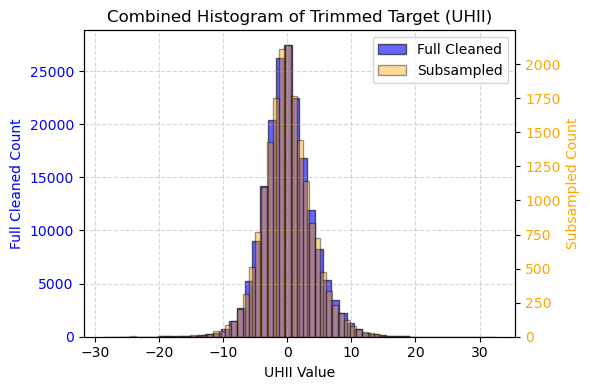

In [8]:
plot_combined_y_histogram(y_full_trimmed, y_subsampled_trimmed, title="Combined Histogram of Trimmed Target (UHII)")

Explained variance ratio (first 2 components): [0.97373341 0.0248088 ]


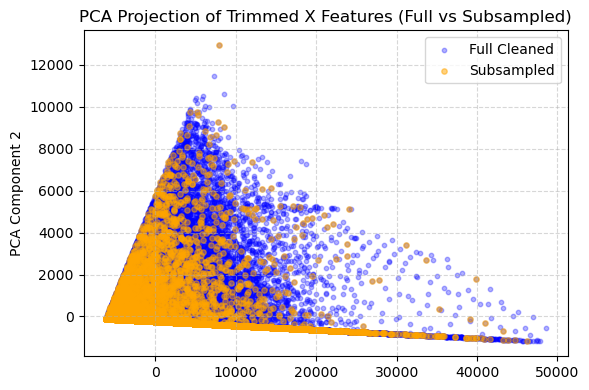

In [9]:
plot_pca_projection(X_full_trimmed, X_subsampled_trimmed, n_components=2, title="PCA Projection of Trimmed X Features (Full vs Subsampled)")

In [10]:
# Save full trimmed
X_full_trimmed.to_csv(os.path.join(save_path, 'X_full_trimmed.csv'), index=False)
y_full_trimmed.to_csv(os.path.join(save_path, 'y_full_trimmed.csv'), index=False)
lat_lon_full_trimmed.to_csv(os.path.join(save_path, 'lat_lon_full_trimmed.csv'), index=False)
original_index_full_trimmed.to_csv(os.path.join(save_path, 'original_index_full_trimmed.csv'), index=False)

# Save downsampled trimmed
X_subsampled_trimmed.to_csv(os.path.join(save_path, 'X_subsampled_trimmed.csv'), index=False)
y_subsampled_trimmed.to_csv(os.path.join(save_path, 'y_subsampled_trimmed.csv'), index=False)
lat_lon_subsampled_trimmed.to_csv(os.path.join(save_path, 'lat_lon_subsampled_trimmed.csv'), index=False)
original_index_subsampled_trimmed.to_csv(os.path.join(save_path, 'original_index_subsampled_trimmed.csv'), index=False)

print("Saved all trimmed and downsampled-trimmed datasets successfully!")

Saved all trimmed and downsampled-trimmed datasets successfully!
